## Problem description:
I found this paper when trying to experiment with different architecture for models working with images: https://arxiv.org/pdf/2205.01972.pdf
In summary, the paper handles on using a sequencer arquitecture (inspired by the advances of that architecture in natural languages processes, replacing the attention layer with LSTM).
I found interesting to try to experiment with different architectures for image recognition.
There are several arguments in favor for this approach:
1. One could consider images as sequences of pixels (the same way as texts are sequences of words)
2. There is meaning on how pixel sequences relates to each other
3. Pixel could seen as meaningful and carry one value among (in the case of MNIST) 256 others.

One could argue against this approach, since pixels are not exact analogies of words, and this approach is a bit naive.

However I found very interested to check if there are other approaches to convolutional networks in image recognition that could give good results.


I will be using the MNIST dataset (downloaded from Kaggle). This because:
* images in MNIST are only 28x28 pixels, making them easy to work even with limited HW resources
* datasets from Kaggle normally need little data cleaning
* all the data in one dataset

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
! kaggle competitions download -c 'digit-recognizer'
! mkdir dataset
! unzip -qq digit-recognizer.zip -d dataset

  0% 0.00/15.3M [00:00<?, ?B/s]
100% 15.3M/15.3M [00:00<00:00, 187MB/s]


#### Importing the necessary packages

In [ ]:
!pip install -q -U keras-tuner

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
import keras_tuner as kt
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

In [ ]:
df = pd.read_csv('/content/dataset/train.csv')
df_test = pd.read_csv('/content/dataset/test.csv')

### EDA
My strategy for data preprocessing and exploratory analysis is:
1. Get an idea of the overall composition of the dataset
2. Find out the size of the dataset
3. Visualize the images (in this case digits)
4. Normalize the pixel values
5. Transform the data if necessary. In this case, it was. The images were store each pixel in one column, resulting in 784 columns for the image content only. I procedded to reshape the data to a column with an array of 28x28. For LSTM, we need to reshape the images so they become a sequence of sequences. 28 sequences of 28 elements.
6. Visualize the distribution to make sure the dataset is balanced.

In [ ]:
print(df.info())
print(df.describe())
print(df.head())
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None
              label   pixel0   pixel1   pixel2   pixel3   pixel4   pixel5  \
count  42000.000000  42000.0  42000.0  42000.0  42000.0  42000.0  42000.0   
mean       4.456643      0.0      0.0      0.0      0.0      0.0      0.0   
std        2.887730      0.0      0.0      0.0      0.0      0.0      0.0   
min        0.000000      0.0      0.0      0.0      0.0      0.0      0.0   
25%        2.000000      0.0      0.0      0.0      0.0      0.0      0.0   
50%        4.000000      0.0      0.0      0.0      0.0      0.0      0.0   
75%        7.000000      0.0      0.0      0.0      0.0      0.0      0.0   
max        9.000000      0.0      0.0      0.0      0.0      0.0      0.0   

        pixel6   pixel7   pixel8  ...      pixel774      pixel775  \
count  42000.0  42000.0  42000.0  ...  42000.000000  42000.000000   
mean 

In [ ]:
print(df_test.info())
print(df_test.describe())
print(df_test.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB
None
        pixel0   pixel1   pixel2   pixel3   pixel4   pixel5   pixel6   pixel7  \
count  28000.0  28000.0  28000.0  28000.0  28000.0  28000.0  28000.0  28000.0   
mean       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
std        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
min        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
25%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
50%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
75%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
max        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

        pixel8   pixel9  ...      pixel774      pixel775      pixel776  \
count  28000.0  28000.0  ...  28

#### Check the distribution of digits in the dataset

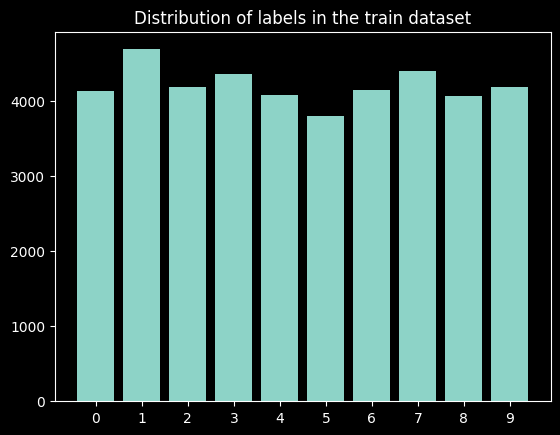

In [ ]:

value_counts = df.label.value_counts()
value_counts_sorted = value_counts.sort_index()

plt.style.use('dark_background')

plt.bar(value_counts_sorted.index, value_counts_sorted.values)
plt.xticks(range(len(value_counts_sorted.index)), value_counts_sorted.index)
plt.title("Distribution of labels in the train dataset")
plt.show()

In [ ]:
def convert_to_array(serie, nr_rows, nr_columns):
  # normalize
  normalized_row = serie / 127.0
  array = normalized_row.values.astype(np.float16)
  return np.reshape(array, (nr_rows, nr_columns))

def get_image_label(df, index):
  row = df.iloc[index]
  label = row[0]
  array = convert_to_array(row[1:], 28, 28)
  return array, label


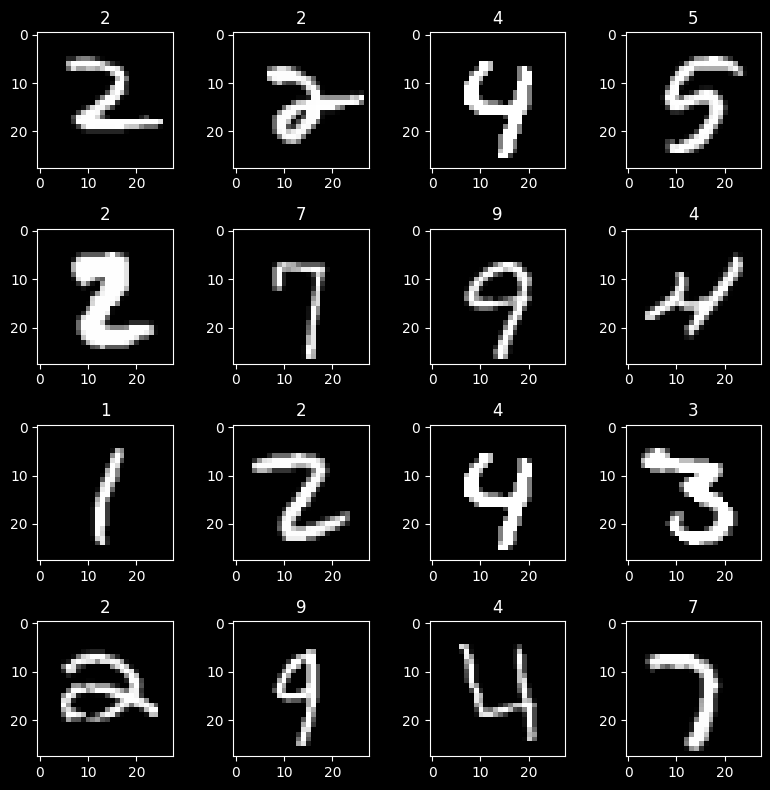

In [ ]:
# this function is taken from my own delivery (from week 3)
indices = [random.randint(1, 100) for i in range(16)]

def plot_images(df):
  images = []
  subtitles = []
  for index in indices:
    image, label = get_image_label(df, index)
    images.append(image)
    subtitle = str(label)
    subtitles.append(subtitle)
  fig, axes = plt.subplots(4, 4, figsize=(8, 8))

  for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap='gray')
    ax.title.set_text(subtitles[i])
    ax.axis("on")
  plt.style.use('dark_background')
  plt.tight_layout()
  plt.show()

# Plotting some random images
plot_images(df)

I splitted the dataset in a train and a validation dataset

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.15, random_state=42, shuffle=True)

In [ ]:
train_df['digit'] = train_df.apply(lambda row: convert_to_array(row[1:], 28, 28), axis=1)
val_df['digit'] = val_df.apply(lambda row: convert_to_array(row[1:], 28, 28), axis=1)



In [ ]:
X_train = np.array(train_df['digit'].tolist())
nr_images = X_train.shape[0]
X_train = X_train.reshape(nr_images, 28, 28, 1)
y_train = train_df['label']


X_val = np.array(val_df['digit'].tolist())
nr_images = X_val.shape[0]
X_val = X_val.reshape(nr_images, 28, 28, 1)
y_val = val_df['label']

## General information about the models (ML):

1. I tried to keep all mdels at the same complexity level, trying to keep the complexity down. No model used transfer learning
2. All models (except one) were tuned (se the next cell for more information about hyperparameter tunning)
3. All models were trained for 5 epochs and used the same train and validation data
4. I used TensorFlow
5. All models were sequential and none have concatenating connections between layers


The models compared in this notebook are:
* A classic CNN model
* A hybrid model CNN-LSTM
* An unidirectional LSTM model
* A bidirectional LSTM model
* A bidirectional GRU model

### Hyperparameter tunning:
Some words about hyperparameter tunning on this notebook:
Almost all models tested used Keras tuner for hyperparamter tunning. This automate the process to find the best parameters a lot easier.
The parameters that were included were: number of units per layer and learning rate of the model.

I could have included optimizer types or activation function, but I wanted to keep the scope to the comparison of models.

### First try with a classical CNN.
The model consists of two convolutional blocks (2 convolutional layers + 1 max pooling layer) connected to a dense NN.

In [ ]:
def model_classic_cnn(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(hp.Int('conv1_units', min_value=64, max_value=256, step=32), (3,3), activation = 'relu', input_shape=(28, 28, 1)))
    model.add(tf.keras.layers.Conv2D(hp.Int('conv2_units', min_value=64, max_value=256, step=32), (3,3), activation = 'relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(hp.Int('conv3_units', min_value=64, max_value=256, step=32), (3,3), activation = 'relu'))
    model.add(tf.keras.layers.Conv2D(hp.Int('conv4_units', min_value=128, max_value=512, step=32), (3,3), activation = 'relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(hp.Int('dense1_units', min_value=96, max_value=256, step=32), activation= 'relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    model.compile(optimizer= Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])), loss='sparse_categorical_crossentropy', metrics='accuracy')
    return model

tuner = kt.Hyperband(model_classic_cnn,
                     objective='accuracy',
                     max_epochs=5,
                     factor=3,
                     directory='/content/models',
                     project_name='cnn_classic')

In [ ]:
tuner.search(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

Trial 10 Complete [00h 01m 08s]
accuracy: 0.9912885427474976

Best accuracy So Far: 0.991820752620697
Total elapsed time: 00h 08m 05s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("Best Hyperparameters:")
print(f" - conv1_units: {best_hps.get('conv1_units')}")
print(f" - conv2_units: {best_hps.get('conv2_units')}")
print(f" - conv1_units: {best_hps.get('conv3_units')}")
print(f" - conv2_units: {best_hps.get('conv4_units')}")
print(f" - dense1_units: {best_hps.get('dense1_units')}")
print(f" - learning_rate: {best_hps.get('learning_rate')}")

Best Hyperparameters:
 - conv1_units: 160
 - conv2_units: 160
 - conv1_units: 256
 - conv2_units: 256
 - dense1_units: 192
 - learning_rate: 0.0001


### I printed this to avoid running tuning several times:

Best accuracy So Far: 0.991820752620697


Best Hyperparameters:
 - conv1_units: 160
 - conv2_units: 160
 - conv1_units: 256
 - conv2_units: 256
 - dense1_units: 192
 - learning_rate: 0.0001

In [ ]:
best_ccn_classic = tf.keras.Sequential()
best_ccn_classic.add(tf.keras.layers.Conv2D(160, (3,3), activation = 'relu', input_shape=(28, 28, 1)))
best_ccn_classic.add(tf.keras.layers.Conv2D(160, (3,3), activation = 'relu'))
best_ccn_classic.add(tf.keras.layers.MaxPooling2D((2, 2)))
best_ccn_classic.add(tf.keras.layers.Conv2D(256, (3,3), activation = 'relu'))
best_ccn_classic.add(tf.keras.layers.Conv2D(256, (3,3), activation = 'relu'))
best_ccn_classic.add(tf.keras.layers.MaxPooling2D((2, 2)))
best_ccn_classic.add(tf.keras.layers.Flatten())
best_ccn_classic.add(tf.keras.layers.Dropout(0.2))
best_ccn_classic.add(tf.keras.layers.Dense(192, activation= 'relu'))
best_ccn_classic.add(tf.keras.layers.Dropout(0.2))
best_ccn_classic.add(tf.keras.layers.Dense(10, activation='softmax'))
best_ccn_classic.compile(optimizer= Adam(learning_rate = 1e-3), loss='sparse_categorical_crossentropy', metrics='accuracy')
history_cnn_classic = best_ccn_classic.fit(X_train, y_train, validation_data=(X_val, y_val), epochs= 5)

Epoch 1/5
1116/1116 [==============================] - 27s 14ms/step - loss: 0.1471 - accuracy: 0.9541 - val_loss: 0.0518 - val_accuracy: 0.9825
Epoch 2/5
1116/1116 [==============================] - 13s 11ms/step - loss: 0.0538 - accuracy: 0.9836 - val_loss: 0.0402 - val_accuracy: 0.9876
Epoch 3/5
1116/1116 [==============================] - 13s 11ms/step - loss: 0.0389 - accuracy: 0.9880 - val_loss: 0.0315 - val_accuracy: 0.9902
Epoch 4/5
1116/1116 [==============================] - 12s 11ms/step - loss: 0.0312 - accuracy: 0.9916 - val_loss: 0.0365 - val_accuracy: 0.9881
Epoch 5/5
1116/1116 [==============================] - 13s 12ms/step - loss: 0.0229 - accuracy: 0.9928 - val_loss: 0.0320 - val_accuracy: 0.9908


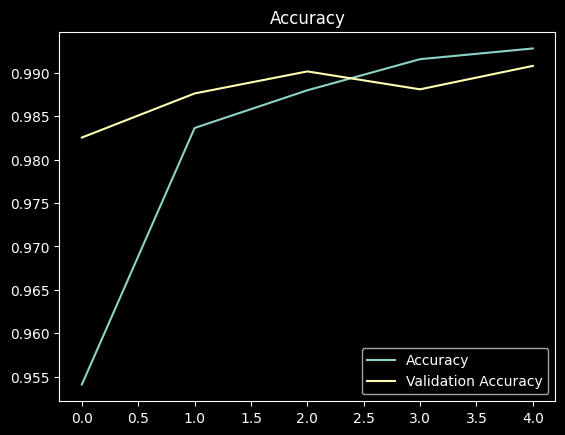

In [ ]:

plt.plot(history_cnn_classic.history['accuracy'])
plt.plot(history_cnn_classic.history['val_accuracy'])
plt.title("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"],loc="lower right")
plt.show()

### Then try a hybrid model:
The architecture of the model is one convolution block (as before), then reshape the output of the part as a sequence for the input to the two LSTM layers followed by a last dense layer.
One convolutional block AND one dense layer from the previous model was replace by the two LSTM layers.

I got some input from these papers:

https://www.warse.org/IJETER/static/pdf/file/ijeter148872020.pdf
https://tc.copernicus.org/articles/16/1447/2022/tc-16-1447-2022.pdf

One lesson learnt: The only challenge of this model is that one have to make sure that the output of the convolutional block is compatible with the expected input of the first LSTM layer. This thread helped: https://groups.google.com/g/keras-users/c/_awG_uezkXY?pli=1

In [ ]:
def model_cnn_lstm_hybrid(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(hp.Int('conv1_units', min_value=64, max_value=256, step=32), (3,3), activation = 'relu', input_shape=(28, 28, 1)))
    model.add(tf.keras.layers.Conv2D(hp.Int('conv2_units', min_value=64, max_value=256, step=32), (3,3), activation = 'relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.BatchNormalization())

    conv_output_shape = model.layers[-1].output_shape[1:]
    reshape_value = conv_output_shape[0]

    model.add(tf.keras.layers.Reshape((1, reshape_value)))
    model.add(tf.keras.layers.LSTM(hp.Int('lstm1_units', min_value=64, max_value=128, step=32), return_sequences=True))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LSTM(hp.Int('lstm2_units', min_value=64, max_value=128, step=32)))
    model.add(tf.keras.layers.Dense(hp.Int('dense2_units', min_value=96, max_value=256, step=32), activation= 'relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    model.compile(optimizer= Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])), loss='sparse_categorical_crossentropy', metrics='accuracy')
    return model

tuner = kt.Hyperband(model_cnn_lstm_hybrid,
                     objective='accuracy',
                     max_epochs=5,
                     factor=3,
                     directory='/content/models',
                     project_name='cnn_lstm_hybrid_condensed')

In [ ]:
tuner.search(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

Trial 10 Complete [00h 02m 29s]
accuracy: 0.99420166015625

Best accuracy So Far: 0.99420166015625
Total elapsed time: 00h 12m 23s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("Best Hyperparameters:")
print(f" - conv1_units: {best_hps.get('conv1_units')}")
print(f" - conv2_units: {best_hps.get('conv2_units')}")
print(f" - lstm1_units: {best_hps.get('lstm1_units')}")
print(f" - lstm2_units: {best_hps.get('lstm2_units')}")
print(f" - dense2_units: {best_hps.get('dense2_units')}")
print(f" - learning_rate: {best_hps.get('learning_rate')}")

Best Hyperparameters:
 - conv1_units: 160
 - conv2_units: 192
 - lstm1_units: 128
 - lstm2_units: 128
 - dense2_units: 256
 - learning_rate: 0.0001


Best Hyperparameters:
 - conv1_units: 160
 - conv2_units: 192
 - lstm1_units: 128
 - lstm2_units: 128
 - dense2_units: 256
 - learning_rate: 0.0001

In [ ]:
best_ccn_hybrid = tf.keras.Sequential()
best_ccn_hybrid.add(tf.keras.layers.Conv2D(160, (3,3), activation = 'relu', input_shape=(28, 28, 1)))
best_ccn_hybrid.add(tf.keras.layers.Conv2D(192, (3,3), activation = 'relu'))
best_ccn_hybrid.add(tf.keras.layers.MaxPooling2D((2, 2)))
best_ccn_hybrid.add(tf.keras.layers.Flatten())
best_ccn_hybrid.add(tf.keras.layers.BatchNormalization())

conv_output_shape = best_ccn_hybrid.layers[-1].output_shape[1:]

reshape_value = conv_output_shape[0]

best_ccn_hybrid.add(tf.keras.layers.Reshape((1, reshape_value)))
best_ccn_hybrid.add(tf.keras.layers.LSTM(128, return_sequences=True))
best_ccn_hybrid.add(tf.keras.layers.BatchNormalization())
best_ccn_hybrid.add(tf.keras.layers.LSTM(128))
best_ccn_hybrid.add(tf.keras.layers.Dense(256, activation= 'relu'))
best_ccn_hybrid.add(tf.keras.layers.Dropout(0.2))
best_ccn_hybrid.add(tf.keras.layers.Dense(10, activation='softmax'))
best_ccn_hybrid.compile(optimizer= Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics='accuracy')
history_cnn_hybrid = best_ccn_hybrid.fit(X_train, y_train, validation_data=(X_val, y_val), epochs= 5)

Epoch 1/5
1116/1116 [==============================] - 32s 20ms/step - loss: 0.2938 - accuracy: 0.9566 - val_loss: 0.0633 - val_accuracy: 0.9821
Epoch 2/5
1116/1116 [==============================] - 21s 19ms/step - loss: 0.0518 - accuracy: 0.9861 - val_loss: 0.0520 - val_accuracy: 0.9838
Epoch 3/5
1116/1116 [==============================] - 22s 20ms/step - loss: 0.0303 - accuracy: 0.9913 - val_loss: 0.0380 - val_accuracy: 0.9884
Epoch 4/5
1116/1116 [==============================] - 22s 19ms/step - loss: 0.0204 - accuracy: 0.9947 - val_loss: 0.0413 - val_accuracy: 0.9873
Epoch 5/5
1116/1116 [==============================] - 21s 19ms/step - loss: 0.0146 - accuracy: 0.9953 - val_loss: 0.0443 - val_accuracy: 0.9875


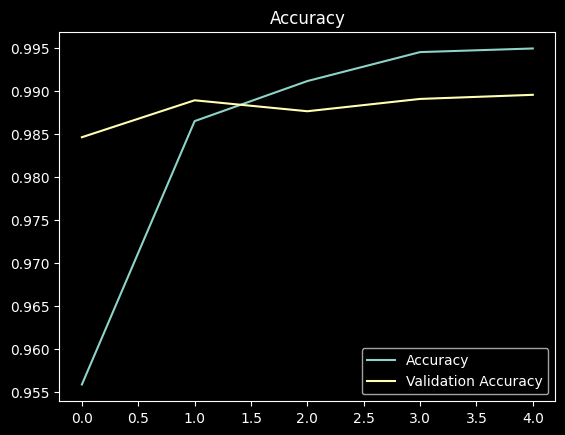

In [ ]:
plt.plot(history_cnn_hybrid.history['accuracy'])
plt.plot(history_cnn_hybrid.history['val_accuracy'])
plt.title("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"],loc="lower right")
plt.show()

I decided to simplify the model even more. I removed one of the LSTM layers.

In [ ]:
def model_cnn_lstm_condensed(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(hp.Int('conv1_units', min_value=64, max_value=256, step=32), (3,3), activation = 'relu', input_shape=(28, 28, 1)))
    model.add(tf.keras.layers.Conv2D(hp.Int('conv2_units', min_value=64, max_value=256, step=32), (3,3), activation = 'relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.BatchNormalization())

    conv_output_shape = model.layers[-1].output_shape[1:]
    print("Output values is: ", conv_output_shape)
    reshape_value = conv_output_shape[0]
    print("Reshape value is: ", reshape_value)

    model.add(tf.keras.layers.Reshape((1, reshape_value)))
    model.add(tf.keras.layers.LSTM(hp.Int('lstm1_units', min_value=64, max_value=128, step=32)))
    model.add(tf.keras.layers.Dense(hp.Int('dense2_units', min_value=96, max_value=256, step=32), activation= 'relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    model.compile(optimizer= Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])), loss='sparse_categorical_crossentropy', metrics='accuracy')
    return model

tuner = kt.Hyperband(model_cnn_lstm_condensed,
                     objective='accuracy',
                     max_epochs=5,
                     factor=3,
                     directory='/content/models',
                     project_name='cnn_lstm_hybrid_condensed')

Output values is:  (9216,)
Reshape value is:  9216


In [ ]:
tuner.search(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

Trial 10 Complete [00h 01m 27s]
accuracy: 0.9960224032402039

Best accuracy So Far: 0.9960224032402039
Total elapsed time: 00h 10m 42s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("Best Hyperparameters:")
print(f" - conv1_units: {best_hps.get('conv1_units')}")
print(f" - conv2_units: {best_hps.get('conv2_units')}")
print(f" - lstm1_units: {best_hps.get('lstm1_units')}")
print(f" - dense2_units: {best_hps.get('dense2_units')}")
print(f" - learning_rate: {best_hps.get('learning_rate')}")

Best Hyperparameters:
 - conv1_units: 96
 - conv2_units: 192
 - lstm1_units: 64
 - dense2_units: 224
 - learning_rate: 0.0001


#### Just to avoid running hyperparameter tuning several times

Best Hyperparameters:
 - conv1_units: 96
 - conv2_units: 192
 - lstm1_units: 64
 - dense2_units: 224
 - learning_rate: 0.0001

In [ ]:
best_hybrid_condensed = tf.keras.Sequential()
best_hybrid_condensed.add(tf.keras.layers.Conv2D(96, (3,3), activation = 'relu', input_shape=(28, 28, 1)))
best_hybrid_condensed.add(tf.keras.layers.Conv2D(192, (3,3), activation = 'relu'))
best_hybrid_condensed.add(tf.keras.layers.MaxPooling2D((2, 2)))
best_hybrid_condensed.add(tf.keras.layers.Flatten())
best_hybrid_condensed.add(tf.keras.layers.BatchNormalization())

# calculating reshaping for LSTM layer
conv_output_shape = best_hybrid_condensed.layers[-1].output_shape[1:]
reshape_value = conv_output_shape[0]

best_hybrid_condensed.add(tf.keras.layers.Reshape((1, reshape_value)))
best_hybrid_condensed.add(tf.keras.layers.LSTM(128, return_sequences=True))
best_hybrid_condensed.add(tf.keras.layers.BatchNormalization())
best_hybrid_condensed.add(tf.keras.layers.LSTM(128))
best_hybrid_condensed.add(tf.keras.layers.Dense(10, activation='softmax'))
best_hybrid_condensed.compile(optimizer= Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics='accuracy')
history_hybrid_condensed = best_hybrid_condensed.fit(X_train, y_train, validation_data=(X_val, y_val), epochs= 5)

Epoch 1/5
1116/1116 [==============================] - 30s 19ms/step - loss: 0.2772 - accuracy: 0.9618 - val_loss: 0.0607 - val_accuracy: 0.9871
Epoch 2/5
1116/1116 [==============================] - 20s 18ms/step - loss: 0.0543 - accuracy: 0.9876 - val_loss: 0.0441 - val_accuracy: 0.9879
Epoch 3/5
1116/1116 [==============================] - 20s 18ms/step - loss: 0.0279 - accuracy: 0.9931 - val_loss: 0.0359 - val_accuracy: 0.9894
Epoch 4/5
1116/1116 [==============================] - 19s 17ms/step - loss: 0.0182 - accuracy: 0.9952 - val_loss: 0.0423 - val_accuracy: 0.9878
Epoch 5/5
1116/1116 [==============================] - 19s 17ms/step - loss: 0.0137 - accuracy: 0.9964 - val_loss: 0.0380 - val_accuracy: 0.9894


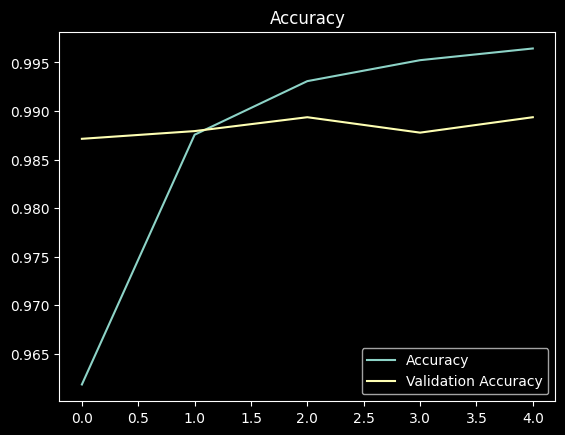

In [ ]:
plt.plot(history_hybrid_condensed.history['accuracy'])
plt.plot(history_hybrid_condensed.history['val_accuracy'])
plt.title("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"],loc="lower right")
plt.show()

## Then try models without convolutional layers and only using LSTM or GRU layers

In the paper from Yuki Tatsunami and Masato Taki, they used a much more complex architecture. The LSTM layers not only were bidirectional (meaning that they could extract information from the sequences both in the forward and backward directions), but they look at the images vertically and horizontally.

I simplified this approach, and all the models presented in this notebook only look at the information **HORIZONTALLY**.

I had to reshape the X_train and X_val so the input to the LSTM layers were as expected

In [ ]:

X_train_lstm = np.reshape(X_train, (-1, 28, 28))
X_val_lstm = np.reshape(X_val, (-1, 28, 28))

print(X_train_lstm.shape)
print(X_train.shape)

(35700, 28, 28)
(35700, 28, 28, 1)


I decided to check the performance of a model that had an unidirectional LSTM laeryer (that only gets information presented in the forward direction in the sequence).

The architecture of the model is very simple:
One LSTM layer connected to a dense layer (could not be more simple than that).

In [ ]:
lstm_model = tf.keras.Sequential()
lstm_model.add(tf.keras.layers.Reshape((28,28)))
lstm_model.add(tf.keras.layers.LSTM(128))
lstm_model.add(tf.keras.layers.Dense(10, activation='softmax'))
lstm_model.compile(loss= 'sparse_categorical_crossentropy', optimizer = Adam(learning_rate=0.001), metrics = ['accuracy'])
history_lstm_uni = lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs= 5)

Epoch 1/5
1116/1116 [==============================] - 9s 6ms/step - loss: 0.3828 - accuracy: 0.8735 - val_loss: 0.1357 - val_accuracy: 0.9616
Epoch 2/5
1116/1116 [==============================] - 6s 5ms/step - loss: 0.1136 - accuracy: 0.9654 - val_loss: 0.1117 - val_accuracy: 0.9648
Epoch 3/5
1116/1116 [==============================] - 7s 6ms/step - loss: 0.0782 - accuracy: 0.9757 - val_loss: 0.0722 - val_accuracy: 0.9802
Epoch 4/5
1116/1116 [==============================] - 6s 5ms/step - loss: 0.0604 - accuracy: 0.9817 - val_loss: 0.0692 - val_accuracy: 0.9773
Epoch 5/5
1116/1116 [==============================] - 7s 6ms/step - loss: 0.0498 - accuracy: 0.9845 - val_loss: 0.0635 - val_accuracy: 0.9800


The second LSTM model, uses the same architecture of the first one, but this includes a bidirectional layer that in principle acts as two LSTM layers, one looking at the sequence in the forward direction ant the other looking at the backwards direction.

In [ ]:
def model_lstm_condensed(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Reshape((28,28)))
    model.add(tf.keras.layers.Bidirectional((tf.keras.layers.LSTM(hp.Int('lstm1_units', min_value=64, max_value=256, step=32)))))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    model.compile(optimizer= Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])), loss='sparse_categorical_crossentropy', metrics='accuracy')
    return model

tuner = kt.Hyperband(model_lstm_condensed,
                     objective='accuracy',
                     max_epochs=5,
                     factor=3,
                     directory='/content/models',
                     project_name='lstm_bi_condensed')

In [ ]:
tuner.search(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

Trial 10 Complete [00h 00m 48s]
accuracy: 0.950952410697937

Best accuracy So Far: 0.9857702851295471
Total elapsed time: 00h 07m 22s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("Best Hyperparameters:")
print(f" - lstm1_units: {best_hps.get('lstm1_units')}")
print(f" - learning_rate: {best_hps.get('learning_rate')}")

Best Hyperparameters:
 - lstm1_units: 160
 - learning_rate: 0.001



#### Again, printed it here so I didnt have to run hyperparameter tunning several times.

Best accuracy So Far: 0.9857702851295471

Best Hyperparameters:
 - lstm1_units: 160
 - learning_rate: 0.001

In [ ]:
best_lstm = tf.keras.Sequential()
best_lstm.add(tf.keras.layers.Reshape((28,28)))
best_lstm.add(tf.keras.layers.Bidirectional((tf.keras.layers.LSTM(160))))
best_lstm.add(tf.keras.layers.Dense(10, activation='softmax'))
best_lstm.compile(optimizer= Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics='accuracy')
history_lstm = best_lstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs= 5)

Epoch 1/5
1116/1116 [==============================] - 14s 9ms/step - loss: 0.3087 - accuracy: 0.8996 - val_loss: 0.1205 - val_accuracy: 0.9616
Epoch 2/5
1116/1116 [==============================] - 8s 8ms/step - loss: 0.0973 - accuracy: 0.9700 - val_loss: 0.0822 - val_accuracy: 0.9749
Epoch 3/5
1116/1116 [==============================] - 8s 7ms/step - loss: 0.0686 - accuracy: 0.9784 - val_loss: 0.0717 - val_accuracy: 0.9792
Epoch 4/5
1116/1116 [==============================] - 9s 8ms/step - loss: 0.0509 - accuracy: 0.9844 - val_loss: 0.0696 - val_accuracy: 0.9798
Epoch 5/5
1116/1116 [==============================] - 9s 8ms/step - loss: 0.0457 - accuracy: 0.9861 - val_loss: 0.0574 - val_accuracy: 0.9835


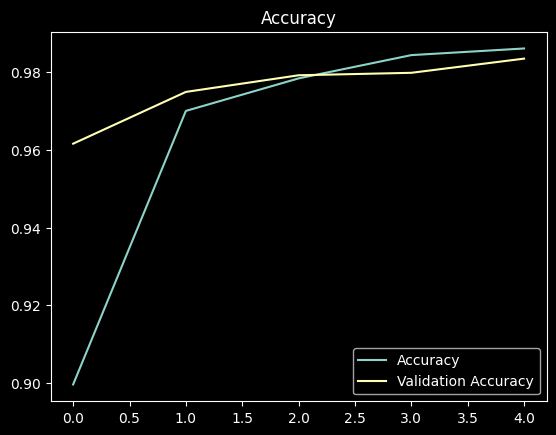

In [ ]:
plt.plot(history_lstm.history['accuracy'])
plt.plot(history_lstm.history['val_accuracy'])
plt.title("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"],loc="lower right")
plt.show()

### And finally: I tried a model with the same architecture of the bidirectional LSTM, but replacing the LSTM layers with GRU (Gated Recurrent Unit)

In [ ]:
def model_gru_condensed(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Reshape((28,28)))
    model.add(tf.keras.layers.GRU(hp.Int('gru_units', min_value=64, max_value=256, step=32)))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    model.compile(optimizer= Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])), loss='sparse_categorical_crossentropy', metrics='accuracy')
    return model

tuner = kt.Hyperband(model_gru_condensed,
                     objective='accuracy',
                     max_epochs=5,
                     factor=3,
                     directory='/content/models',
                     project_name='gru_condensed')

In [ ]:
tuner.search(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

Trial 10 Complete [00h 00m 35s]
accuracy: 0.6008403301239014

Best accuracy So Far: 0.9852941036224365
Total elapsed time: 00h 04m 25s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("Best Hyperparameters:")
print(f" - gru_units: {best_hps.get('gru_units')}")
print(f" - learning_rate: {best_hps.get('learning_rate')}")

Best Hyperparameters:
 - gru_units: 96
 - learning_rate: 0.001


Best accuracy So Far: 0.9852941036224365

Best Hyperparameters:
 - gru_units: 96
 - learning_rate: 0.001

In [ ]:
best_gru = tf.keras.Sequential()
best_gru.add(tf.keras.layers.Reshape((28,28)))
best_gru.add(tf.keras.layers.Bidirectional((tf.keras.layers.GRU(96))))
best_gru.add(tf.keras.layers.Dense(10, activation='softmax'))
best_gru.compile(optimizer= Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics='accuracy')
history_gru = best_gru.fit(X_train, y_train, validation_data=(X_val, y_val), epochs= 5)

Epoch 1/5
1116/1116 [==============================] - 14s 8ms/step - loss: 0.3486 - accuracy: 0.8856 - val_loss: 0.1135 - val_accuracy: 0.9659
Epoch 2/5
1116/1116 [==============================] - 8s 7ms/step - loss: 0.0835 - accuracy: 0.9736 - val_loss: 0.0876 - val_accuracy: 0.9748
Epoch 3/5
1116/1116 [==============================] - 8s 7ms/step - loss: 0.0589 - accuracy: 0.9825 - val_loss: 0.0888 - val_accuracy: 0.9732
Epoch 4/5
1116/1116 [==============================] - 8s 7ms/step - loss: 0.0484 - accuracy: 0.9856 - val_loss: 0.0513 - val_accuracy: 0.9840
Epoch 5/5
1116/1116 [==============================] - 8s 7ms/step - loss: 0.0376 - accuracy: 0.9883 - val_loss: 0.0509 - val_accuracy: 0.9833


## Results and Analysis

First: lets compare training and validation accuracy of the models

Text(0.5, 1.0, 'Scores')

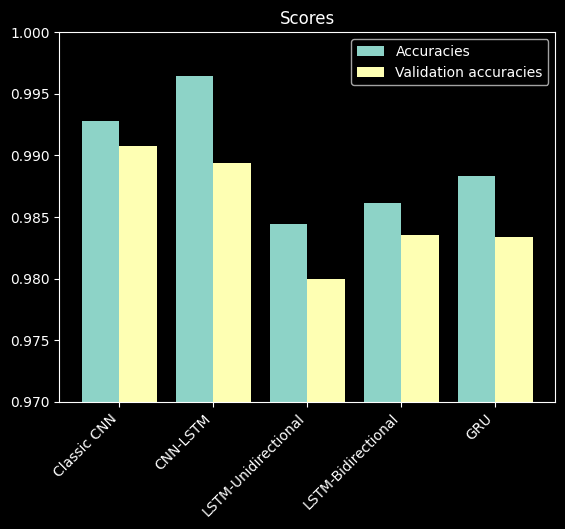

In [ ]:
# https://www.geeksforgeeks.org/plotting-multiple-bar-charts-using-matplotlib-in-python/
models_histories = [history_cnn_classic, history_hybrid_condensed, history_lstm_uni, history_lstm, history_gru]
labels = ['Classic CNN', 'CNN-LSTM', 'LSTM-Unidirectional','LSTM-Bidirectional', 'GRU']
accuracies = []
val_accuracies = []
for model in models_histories:
  accuracies.append(model.history['accuracy'][-1])
  val_accuracies.append(model.history['val_accuracy'][-1])
X_axis = np.arange(len(labels))
plt.bar(X_axis - 0.2, accuracies, 0.4, label = 'Accuracies')
plt.bar(X_axis + 0.2, val_accuracies, 0.4, label = 'Validation accuracies')
plt.xticks(X_axis, labels, rotation=45, ha='right')
plt.ylim(0.97, 1.0)
plt.legend()
plt.title('Scores')

As presented in the papers CNNs still are more accurate than pure RNNs in image recognition.
Another observation that is in harmony with the paper findings is that hybrid networks are even better than pure CNN or RNN networks (**IN AVERAGE**). This is NOT shown in the barplot. The reason is that the performance of the pure CNN and the hybrid CNN-LSTM network varied a bit and since the scale is very very small, sometimes the pure CNN performed just a bit better

When it comes to RNN networks, bidirectional networks have better performance than the unidirectional network (which can be the result of not using Keras Tuner on the later).
As with own previous experiences, GRU networks outperform LSTMs networks when used similar architecture.

In [ ]:
cnn_predictions = tf.argmax(best_ccn_classic.predict(X_val), axis=1)
cnn_lstm_predictions = tf.argmax(best_hybrid_condensed.predict(X_val), axis=1)
lstm_uni_predictions = tf.argmax(lstm_model.predict(X_val_lstm), axis=1)
lstm_bi_predictions = tf.argmax(best_lstm.predict(X_val_lstm), axis=1)
gru_predictions = tf.argmax(best_gru.predict(X_val_lstm), axis=1)

197/197 [==============================] - 1s 3ms/step


In [ ]:
def create_heatmap(y_pred, title, ax):
  plt.figure(figsize=(5, 5))
  cnn_confusion = confusion_matrix(y_val, y_pred)
  sns.heatmap(cnn_confusion, annot=True, cmap="rocket", vmax=20, vmin=-2, fmt='g', ax=ax)
  ax.invert_yaxis()
  ax.set_xlabel("Predicted Values")
  ax.set_ylabel("Real Values")
  ax.set_title(title)


I want to check if there are differences between the networks regarding the digits that they misclassify. To do this, I used confusion matrices, one for each model

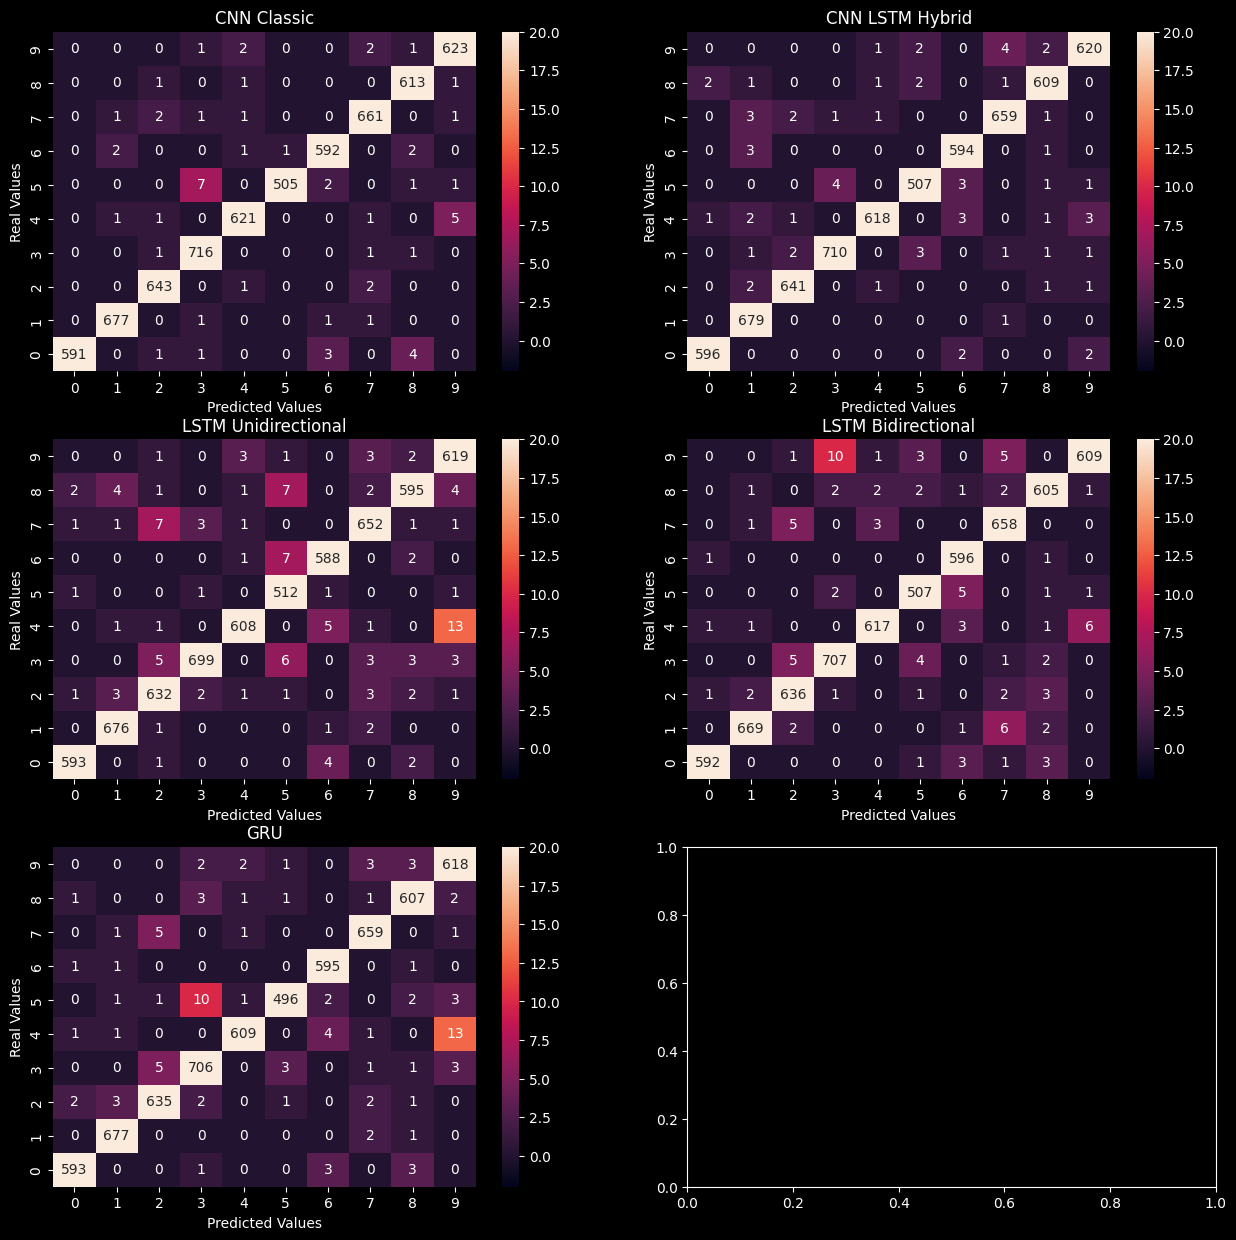

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
create_heatmap(cnn_predictions, "CNN Classic", axes[0, 0])
create_heatmap(cnn_lstm_predictions, "CNN LSTM Hybrid", axes[0, 1])
create_heatmap(lstm_uni_predictions, "LSTM Unidirectional", axes[1, 0])
create_heatmap(lstm_bi_predictions, "LSTM Bidirectional", axes[1, 1])
create_heatmap(gru_predictions, "GRU", axes[2, 0])


plt.style.use('dark_background')
#plt.tight_layout()
plt.show()


Lets sumarize the results from the confussion matrices:
\begin{array}{|c|c|} \hline
Model & \text{Most confused (real)} & \text{Next most confused (real)} \\ \hline
\text{CNN Classic} & 5 & 4 \\
\text{CNN LSTM Hybrid} & 5 & 9 \\
\text{LSTM Unidirectional} & 4 & 5/7/8 \\
\text{LSTM Bidirectional} & 9 & 1/4 \\
\text{GRU Bidirectional} & 5 & 4 \\\hline
\end{array}

We can see from the result that (no surprise) the digits 5 and 4 are difficult, especially 5. Most models have problems confusing the real "5" and classifying as "3". The LSTM models seem to have problems mostly with the pair "4" and "9".

Other models found the pair "4" and "9" very confusing too.

Note: I have run this notebook several times and I have noticed that the confussion matrix can vary on the exact numbers that are misclassified, but I can qualitatively conclude that the number pairs mentioned are misclassified consistently.



## Conclusion
1. CNN are very good in image recognition and there is no coincidence they are so widely used in that field
2. It is possible to use RNNs to do image recognition and still achieve good results
3. RNNs where faster to train than CNNs. RNNs where between 40% to 55% faster to train
4. When it comes to digits recognition, there are some numbers that are more difficult than others. It seems that the pairs 3 and 5, 4 and 9 are the most difficult for the majority of the architectures tried
5. Performance in general could have been improved if the models were trained more than 5 epochs
6. I am personally surprised that the RNNs performed so well. It may be related to the fact that the images are quite homogeneous, centered and with not background


## Further work:
1. One possible try could be to try an architecture for the RNNs that included analyzing the images vertically.
2. Try other type of images. I used MNIST, but Zalando's fashion MNIST could be a similar dataset or a dataset with higher resolution images. MNIST images are very low resolution. The result could be completely different. I think that higher resolution images could tip the balance towards CNN due to translational invariance.
3. Try CNN architectures that clearly incorporates encoders and decoders

## Lessons learnt:
1. TensorFlow is a fantastic and easy to use framework, but trying to create hybrid models requires good understanding of the shapes of the inputs and outputs of each layers.
2. It was a good idea to keep the datasources simple and avoiding major challenges with data cleaning and data-preprocessing, focusing on comparing different models.
3. Previously I have stored the dataset in GitHub and used git to get the necessary data for the notebook. I found using Kaggle directly to be easier.
